In [51]:
from cpymad.madx import Madx

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import stats


# standard configurations
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display

# This functions will be used for the printing/plotting (nothing fundamental)
def showTunes():
    print(f'Q1 = {madx.table.summ.q1[0]:1.6}')
    print(f'Q2 = {madx.table.summ.q2[0]:1.6}')
    
def showChroma():
    print(f'DQ1 = {madx.table.summ.dq1[0]:1.6}')
    print(f'DQ2 = {madx.table.summ.dq2[0]:1.6}')

def plotLatticeSeries(ax, series, height=1., v_offset=0., color='r',alpha=0.5,lw=1):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;


In [52]:
def BeamParameters(pc_GeV, en_x_m=5e-6, en_y_m=5e-6, deltap_p=1e-3, verbose=True):
    Brho_Tm=3.3356*pc_GeV # Tm, beam rigidity (approx)
    E_0_GeV=0.9382720813 # GeV, rest mass energy
    E_tot_GeV=np.sqrt(pc_GeV**2+E_0_GeV**2)
    E_kin_GeV=E_tot_GeV-E_0_GeV
    gamma_r=E_tot_GeV/E_0_GeV
    beta_r=pc_GeV/E_tot_GeV
    eg_x_m=en_x_m/gamma_r/beta_r
    eg_y_m=en_y_m/gamma_r/beta_r


    if verbose:
        print(f'''Particle type: proton
        Beam momentum= {pc_GeV:2.3f} GeV/c
        normalized x-emittance= {en_x_m*1e6:2.3f} mm mrad
        normalized y-emittance= {en_y_m*1e6:2.3f} mm mrad
        deltap/p= {deltap_p} 
        -> Beam total energy= {E_tot_GeV:2.3f} GeV
        -> Beam kinetic energy= {E_kin_GeV:2.6f} GeV
        -> Beam rigidity= {Brho_Tm:2.3f} Tm
        -> relativistic beta= {beta_r:2.5f}
        -> relativistic gamma= {gamma_r:2.3f}
        -> geometrical x-emittance= {eg_x_m*1e6:2.3f} mm mrad
        -> geometrical y-emittance= {eg_y_m*1e6:2.3f} mm mrad
        ''')
    return {'pc_GeV': pc_GeV,'Brho_Tm': Brho_Tm,'E_0_GeV': E_0_GeV, 'E_tot_GeV':E_tot_GeV,
            'E_kin_GeV': E_kin_GeV, 'gamma_r': gamma_r, 'beta_r':beta_r, 'en_x_m':en_x_m, 'en_y_m':en_y_m,
            'eg_x_m':eg_x_m, 'eg_y_m':eg_y_m, 'deltap_p':deltap_p}


pc1 = np.sqrt(2*0.9382720813*50*10**(-6))
pc2 = np.sqrt(2*0.9382720813*170*10**(-6))


print('====== Injection Energy ======')
beamFB=BeamParameters(pc1, en_x_m=1e-6, en_y_m=1e-6, deltap_p=2e-4)

print('======== Top Energy ========')
beamFT=BeamParameters(pc2, en_x_m=1e-6, en_y_m=1e-6, deltap_p=2e-4)

====== Injection Energy ======
Particle type: proton
        Beam momentum= 0.010 GeV/c
        normalized x-emittance= 1.000 mm mrad
        normalized y-emittance= 1.000 mm mrad
        deltap/p= 0.0002 
        -> Beam total energy= 0.938 GeV
        -> Beam kinetic energy= 0.000050 GeV
        -> Beam rigidity= 0.032 Tm
        -> relativistic beta= 0.01032
        -> relativistic gamma= 1.000
        -> geometrical x-emittance= 96.864 mm mrad
        -> geometrical y-emittance= 96.864 mm mrad
        
======== Top Energy ========
Particle type: proton
        Beam momentum= 0.018 GeV/c
        normalized x-emittance= 1.000 mm mrad
        normalized y-emittance= 1.000 mm mrad
        deltap/p= 0.0002 
        -> Beam total energy= 0.938 GeV
        -> Beam kinetic energy= 0.000170 GeV
        -> Beam rigidity= 0.060 Tm
        -> relativistic beta= 0.01903
        -> relativistic gamma= 1.000
        -> geometrical x-emittance= 52.532 mm mrad
        -> geometrical y-emittance= 52

In [53]:
madx = Madx(stdout=False)
#madx = Madx()
#f1 = open("Optics_v7.str")
#f2 = open("CRYRING_v7.1.0.seq")
#f2 = open("sis18.lat")


#optics = "\n".join([line for line in f1])
#sequence = "\n".join([line for line in f2])


def input_str(beam):
    return '''
    
    CALL, FILE = "Optics_v7.str";
    CALL, FILE = "CRYRING_v7.1.0.seq";
    
    !kqfl= -5.93263293/18; 
    !kqdl= 1.67121522/12;

    beam, particle = proton, sequence=cryring, energy = {};
    
    use, sequence = cryring;
    
    select, flag=twiss, column=apertype, aper_1, aper_2;
    twiss, file=twiss.txt;
    
    !show,beam%cryring;
    
    
    
    RETURN;
    '''.format(beam['E_tot_GeV'])

cryring_str = input_str(beamFT)


madx.input(cryring_str)

myTwiss=madx.table.twiss.dframe()
showTunes()

Q1 = 2.42
Q2 = 2.42


In [54]:
# option to see the value of the optics functiona also inside the elements
madx.input('''
select,flag=interpolate, class=drift, slice=4, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=16, range=#s/#e;
select,flag=interpolate, class=sbend, slice=10, range=#s/#e;
twiss;
'''
)
myTwissHR=madx.table.twiss.dframe() # HR stands for High Resolution in the s-direction
twissBeforeQCorrection=myTwissHR
summBeforeQCorrection=madx.table.summ

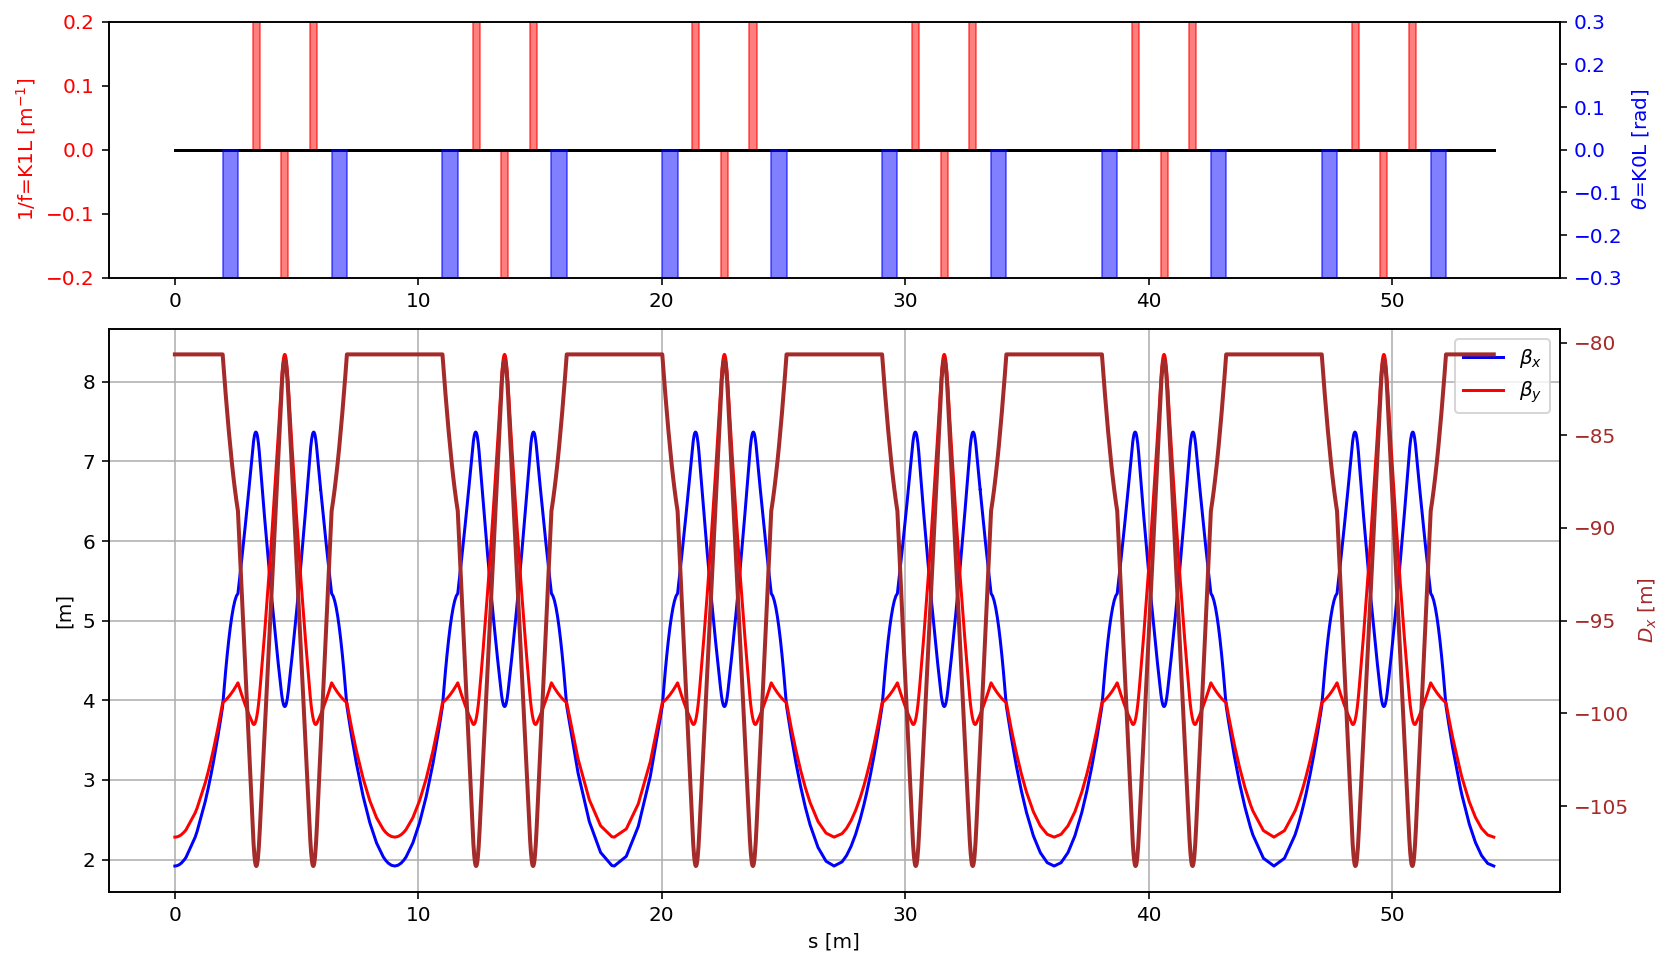

In [55]:
# just plotting
fig = plt.figure(figsize=(13,8))
ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')

DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.2,.2)
#plt.title(f'CAS-19, $\\mu_x$ of the cell={madx.table.summ.Q1[0]/ncell: 2.3f},\
#$\\mu_y$ of the cell={madx.table.summ.Q1[0]/ncell: 2.3f}')
ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)
ax2.tick_params(axis='y', labelcolor=color)

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k2l, v_offset=aux.k2l/2, color='y')

DF=myTwiss[(myTwiss['keyword']=='sbend')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')

    
plt.ylim(-.3,.3)

axbeta=plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwissHR['s'],myTwissHR['betx'],'b', label='$\\beta_x$')
plt.plot(myTwissHR['s'],myTwissHR['bety'],'r', label='$\\beta_y$')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.legend(loc='best')

plt.grid()

ax3 = plt.gca().twinx() 
plt.plot(myTwissHR['s'],myTwissHR['dx'],'brown', label='$D_x$', lw=2)
ax3.set_ylabel('$D_x$ [m]', color='brown')

ax3.tick_params(axis='y', labelcolor='brown')

#plt.ylim(0, -3);

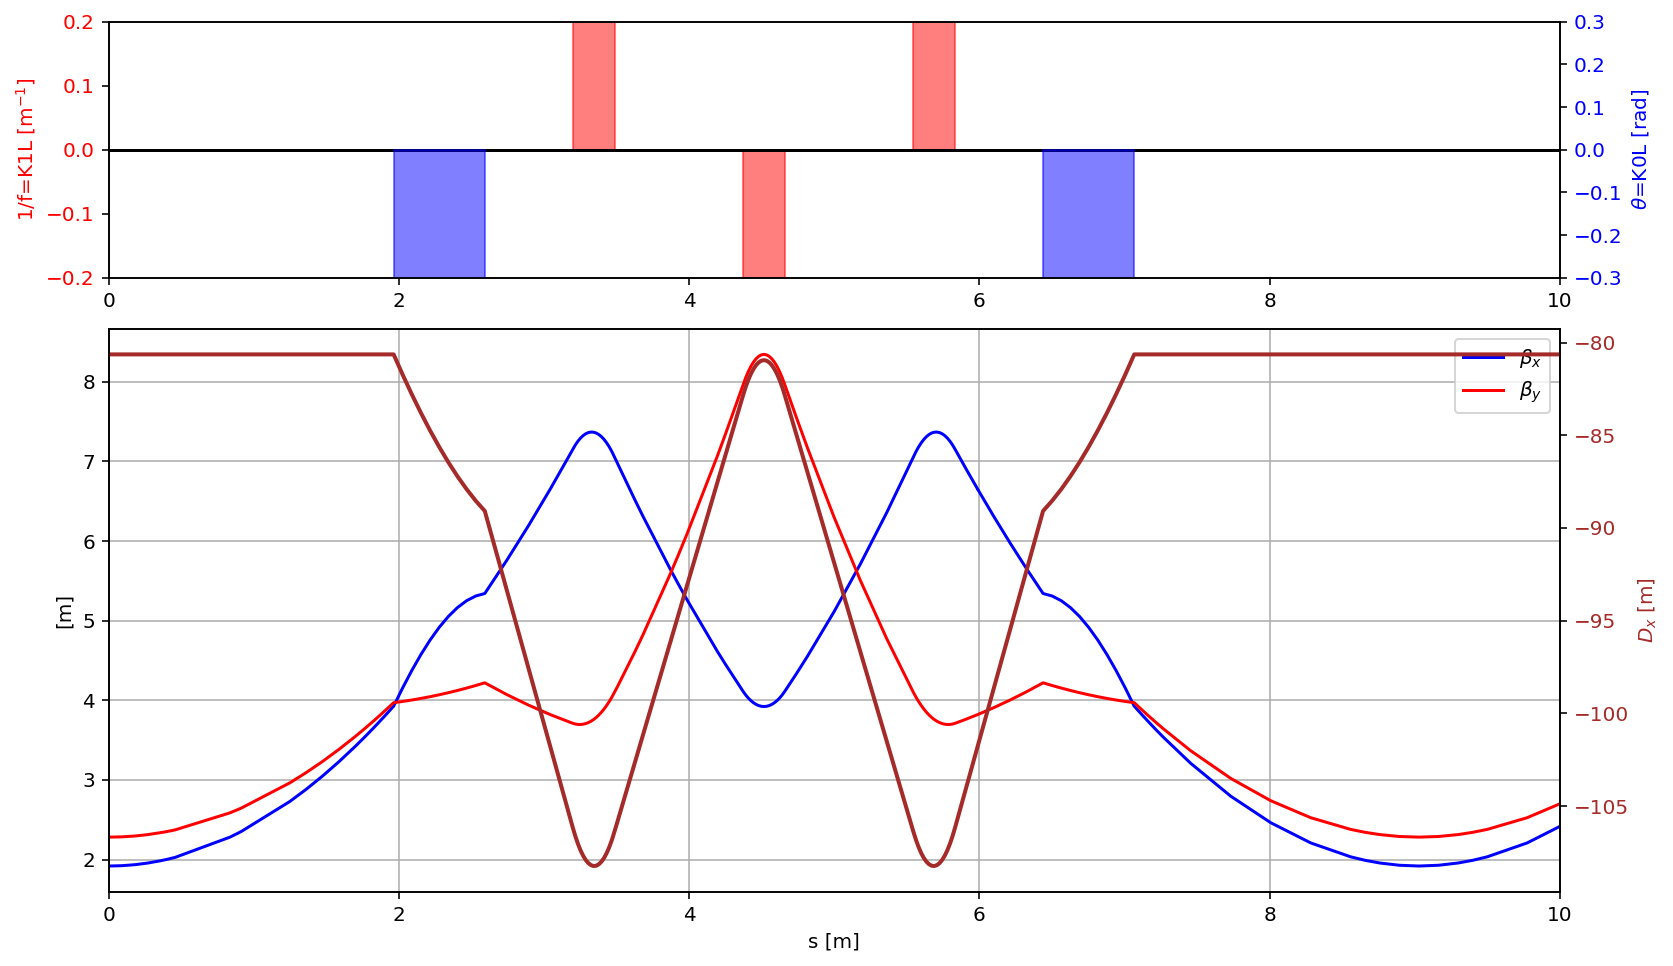

In [56]:
fig.gca().set_xlim(0, 10)
display(fig)

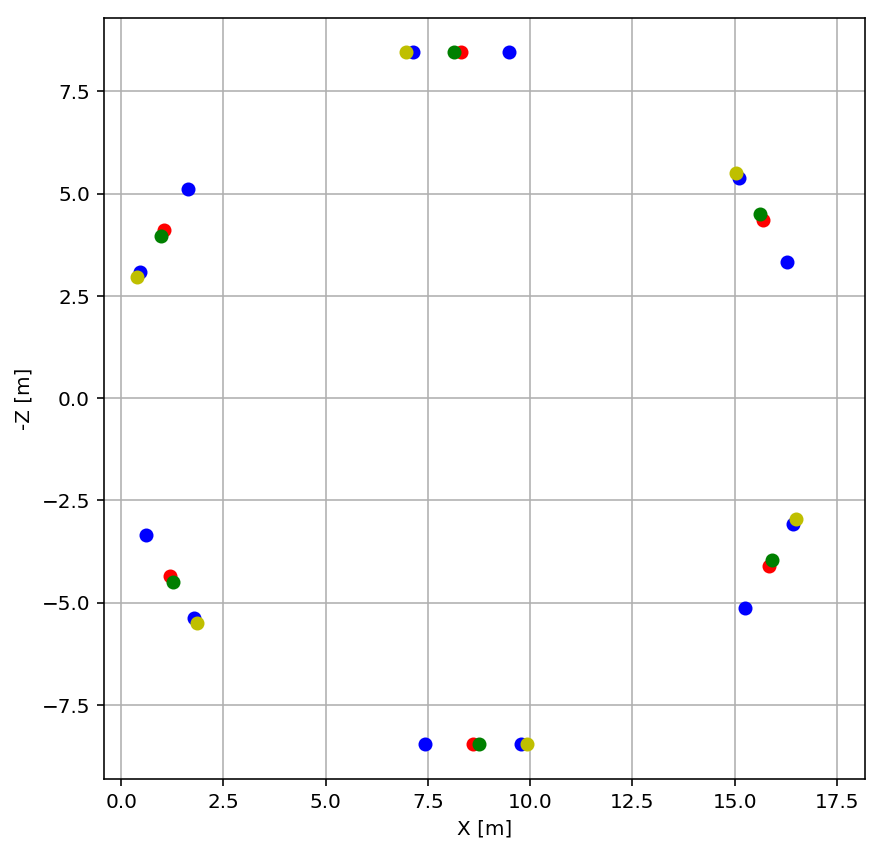

In [57]:
madx.input('survey;')
mySurvey=madx.table.survey.dframe()

qf1Survey=mySurvey[mySurvey['name'].str.contains('qs1')]
qf2Survey=mySurvey[mySurvey['name'].str.contains('qs3')]

qdSurvey=mySurvey[mySurvey['name'].str.contains('qs2')]
mbSurvey=mySurvey[mySurvey['name'].str.contains('mh')]

ms1Survey=mySurvey[mySurvey['name'].str.contains('ks1')]
ms2Survey=mySurvey[mySurvey['name'].str.contains('ks2')]


plt.figure(figsize=(7,7))
plt.plot(qf1Survey.x,-qf1Survey.z,'ob')
plt.plot(qf2Survey.x,-qf2Survey.z,'ob')

plt.plot(qdSurvey.x,-qdSurvey.z,'or')
#plt.plot(mbSurvey.x,-mbSurvey.z,'.k')
plt.plot(ms1Survey.x,-ms1Survey.z,'og')
plt.plot(ms2Survey.x,-ms2Survey.z,'oy')

plt.axis('square');
plt.xlabel('X [m]')
plt.ylabel('-Z [m]')
plt.grid()

In [58]:
def plotAperture(beam):
    pc=beam['pc_GeV']
    madx.input('twiss;')

    myTwissHR['betatronicEnvelope_x']=np.sqrt(myTwissHR['betx']*beam['eg_y_m'])
    myTwissHR['betatronicEnvelope_y']=np.sqrt(myTwissHR['bety']*beam['eg_y_m'])
    myTwissHR['dispersiveEnvelope_x']=myTwissHR['dx']*beam['deltap_p']
    myTwissHR['dispersiveEnvelope_y']=myTwissHR['dy']*beam['deltap_p']
    myTwissHR['envelope_x']=np.sqrt(myTwissHR['betatronicEnvelope_x']**2+(myTwissHR['dx']*beam['deltap_p'])**2)
    myTwissHR['envelope_y']=np.sqrt(myTwissHR['betatronicEnvelope_y']**2+(myTwissHR['dy']*beam['deltap_p'])**2)

    plt.plot(myTwissHR['s'],myTwissHR['envelope_x'],'b')
    plt.plot(myTwissHR['s'],-myTwissHR['envelope_x'],'b')


    plt.fill_between(myTwissHR['s'], myTwissHR['envelope_x'], -myTwissHR['envelope_x'],color='b',alpha=.25)
    plt.fill_between(myTwissHR['s'], 3*myTwissHR['envelope_x'], -3*myTwissHR['envelope_x'],color='b',alpha=.25)

#    plt.xlim(0,lcell_m)
    plt.ylabel('x [m]')
    plt.xlabel('s [m]')

    aux=myTwissHR[myTwissHR['apertype']=='ellipse']
    plt.fill_between(aux['s'], aux['aper_1'], aux['aper_1']*100,color='k',alpha=.5)
    plt.fill_between(aux['s'], -aux['aper_1'], -aux['aper_1']*100,color='k',alpha=.5)

    plt.plot(aux['s'],aux['aper_1'],'k.-')
    plt.plot(aux['s'],-aux['aper_1'],'k.-')

#    plt.xlim(0, lcell_m)
    plt.ylim(-.12, .12)
    plt.title(f'Horizontal aperture at {pc} GeV/c')
    ########################################################################
    plt.figure()

    plt.plot(myTwissHR['s'],myTwissHR['envelope_y'],'r')
    plt.plot(myTwissHR['s'],-myTwissHR['envelope_y'],'r')


    plt.fill_between(myTwissHR['s'], myTwissHR['envelope_y'], -myTwissHR['envelope_y'],color='r',alpha=.25)
    plt.fill_between(myTwissHR['s'], myTwissHR['envelope_y'], -myTwissHR['envelope_y'],color='r',alpha=.25)
    plt.fill_between(myTwissHR['s'], 3*myTwissHR['envelope_y'], -3*myTwissHR['envelope_y'],color='r',alpha=.25)
    plt.fill_between(myTwissHR['s'], 3*myTwissHR['envelope_y'], -3*myTwissHR['envelope_y'],color='r',alpha=.25)

#    plt.xlim(0,lcell_m)
    plt.ylabel('y [m]')
    plt.xlabel('s [m]')

    aux=myTwissHR[myTwissHR['apertype']=='ellipse']
    plt.fill_between(aux['s'], aux['aper_2'], aux['aper_2']*100,color='k',alpha=.5)
    plt.fill_between(aux['s'], -aux['aper_2'], -aux['aper_2']*100,color='k',alpha=.5)

    plt.plot(aux['s'],aux['aper_2'],'k.-')
    plt.plot(aux['s'],-aux['aper_2'],'k.-')

#    plt.xlim(0, lcell_m)
    plt.ylim(-.12, .12)
    plt.title(f'Vertical aperture at {pc} GeV/c')

    plt.figure()
    plt.plot(aux['s'],aux['aper_1']/aux['envelope_x'],'.-b', label='Horizontal plane')
    plt.plot(aux['s'],aux['aper_2']/aux['envelope_y'],'.-r', label='Vertical plane')

    plt.xlim(0, 10)
    plt.grid(True)
    plt.ylabel('n1')
    plt.xlabel('s [m]')
    plt.legend(loc='best')
    plt.title(f'Stay-clear envelope at {pc} GeV/c')

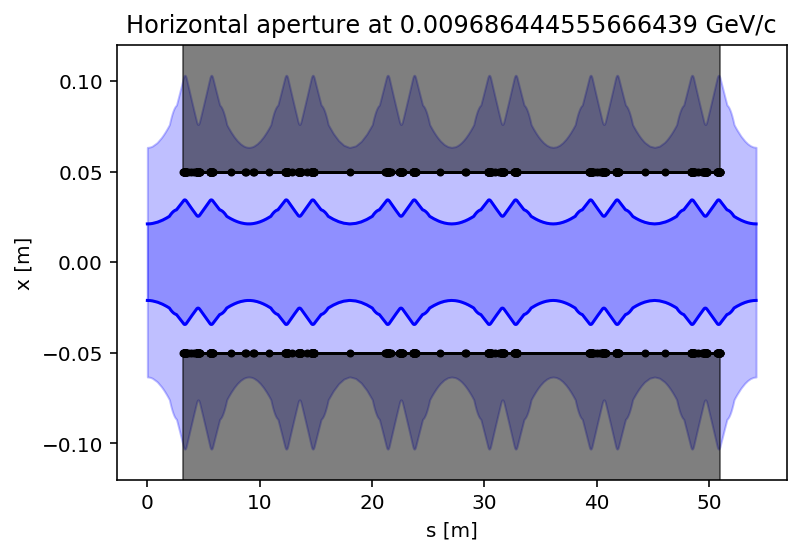

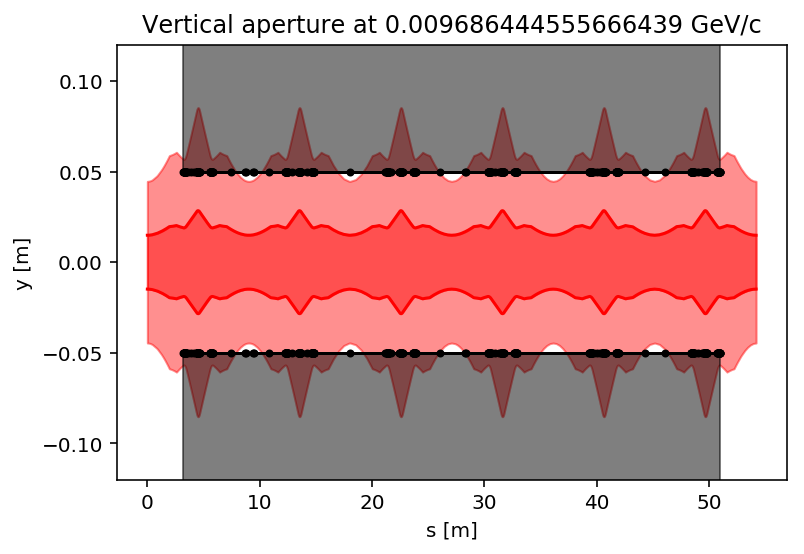

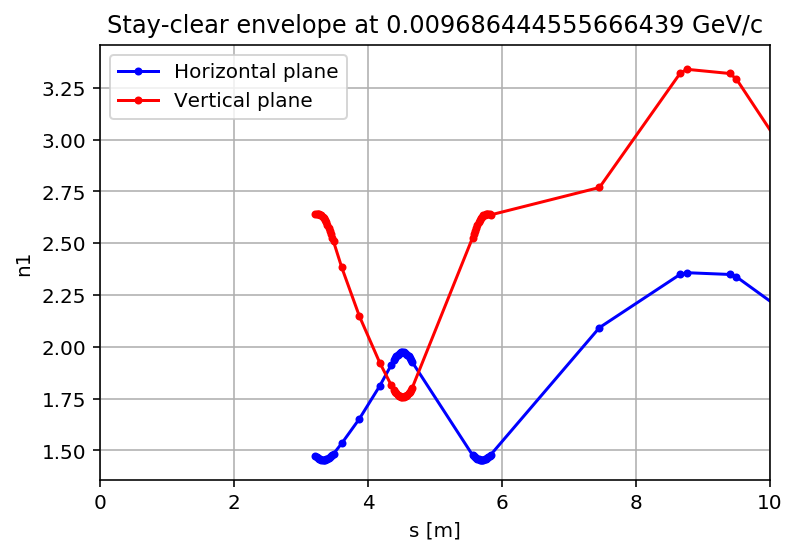

In [59]:
plotAperture(beamFB)

In [ ]:
dt = np.linspace(-0.0002, 0.0002,20)

q1,q2 = [],[]
for dtap in dt:
#    madx.input('''PTC_TWISS,ICASE = 5, NO = 2, deltap = {};'''.format(dtap));
    madx.input('''twiss, deltap={};'''.format(dtap));

#    q1.append(madx.table.ptc_twiss_summary.q1[0])
#    q2.append(madx.table.ptc_twiss_summary.q2[0])
    q1.append(madx.table.summ.q1)
    q2.append(madx.table.summ.q2)



In [68]:
aux=beamFT['deltap_p']
madx.input('ksf=0;ksd=0;twiss, deltap={}:{}:0.00001;'.format(-aux,aux+0.00002));

showChroma()

madx.input('''
PTC_CREATE_UNIVERSE;
PTC_CREATE_LAYOUT, MODEL=1, METHOD=2, NST=2;

SELECT, FLAG=ptc_twiss, CLEAR;
!SELECT, FLAG=ptc_twiss, COLUMN=name, s,disp1;

PTC_TWISS,ICASE = 5, NO = 2;

PTC_END;
''');

Qp1 =madx.table.ptc_twiss_summary.dq1[0]
Qp2 =madx.table.ptc_twiss_summary.dq2[0]

print(madx.table.ptc_twiss_summary.q2[0])
print("ptc chroma {} {}".format(Qp1,Qp2))
print("ptc chroma {} {}".format(Qp1/beamFT["beta_r"],Qp2/beamFT["beta_r"]))

DQ1 = -79.9508
DQ2 = -198.578
0.422577668505844
ptc chroma -2.392521651862525 -2.1742958829910872
ptc chroma -125.70700755946808 -114.24106811610422


In [69]:
sollution = stats.linregress(madx.table.summ.deltap,madx.table.summ.q1)
kx,mx = sollution[0],sollution[1]

sollution = stats.linregress(madx.table.summ.deltap,madx.table.summ.q2)
ky,my = sollution[0],sollution[1]

print("{} {}".format(kx/beamFT["beta_r"] ,ky/beamFT["beta_r"]))
print("{} {}".format(kx ,ky))

-183.67323627547194 -121.71835718892487
-3.4957652973231546 -2.3166075675286057


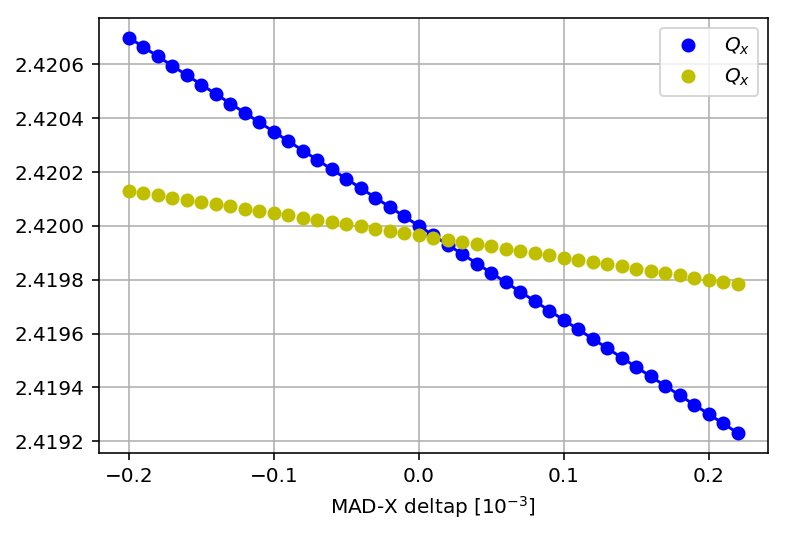

In [70]:
plt.plot(madx.table.summ.deltap*1000,madx.table.summ.q1,'ob', label='$Q_x$')
#plt.plot(madx.table.summ.deltap*1000,madx.table.summ.q2,'or', label='$Q_y$')

plt.plot(madx.table.summ.deltap*1000,madx.table.summ.deltap*kx+mx,'b')
#plt.plot(madx.table.summ.deltap*1000,madx.table.summ.deltap*ky+my,'r')

plt.plot(madx.table.summ.deltap*1000,np.mean(madx.table.summ.q1)+madx.table.summ.deltap*madx.table.summ.dq1[0]*beamFB["beta_r"],'oy', label='$Q_x$')
#plt.plot(madx.table.summ.deltap*1000,np.mean(madx.table.summ.q2)+madx.table.summ.deltap*madx.table.summ.dq2[0]*beamFB["beta_r"],'og', label='$Q_y$')



plt.xlabel('MAD-X deltap [$10^{-3}$]')
plt.grid()
plt.legend(loc='best');


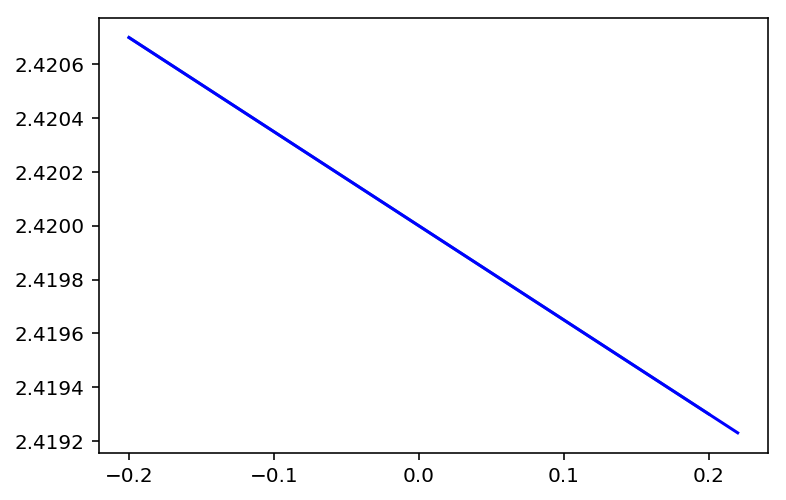

In [71]:
plt.plot(dt*1000,np.array(q1))
#plt.plot(dt*1000,2.+np.array(q2))
#plt.plot(dt*1000,2.42+Qp1*dt)
plt.plot(madx.table.summ.deltap*1000,madx.table.summ.deltap*kx+mx,'b')


In [36]:
# From R. Tomas
# http://cas.web.cern.ch/sites/cas.web.cern.ch/files/lectures/thessaloniki-2018/slidesbeamer.pdf
def Farey (n):
    '''Return the n-th Farey sequence, ascending.''' 
    seq = [[0 , 1]]
    a, b, c, d = 0, 1, 1, n
    while c <= n:
        k = int( (n + b)/d )
        a, b, c, d = c, d, k*c-a, k*d-b
        seq.append([a , b])
    return seq

def plotTuneDiagram():
    fig=plt.figure(figsize=(5,5))
    ax=plt.axes()
    plt.ylim((0,1))
    plt.xlim((0,1))
    x=np.linspace(0,1,1000)
    for i in range(1,4):
        FN=Farey(i) 
        for f in FN:
            h,k=f #Node h/k on the axes
            for sf in FN:
                p,q=sf
                c=float(p*h)
                a=float(k*p) #ResonancelineaQx+bQy=clinkedtop/q
                b=float(q-k*p)
                if a>0:
                    plt.plot(x,c/a-x*b/a,'b',alpha=.1)
                    plt.plot(x,c/a+x*b/a,'b',alpha=.1)
                    plt.plot(c/a-x*b/a,x,'b',alpha=.1)
                    plt.plot(c/a+x*b/a,x,'b',alpha=.1)
                    plt.plot(c/a-x*b/a,1-x,'b',alpha=.1)
                    plt.plot(c/a+x*b/a,1-x,'b',alpha=.1)
                if q==k and p==1: #FNelementsbelow1/k
                    break

    plt.axis('square')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('$Q_x$')
    plt.ylabel('$Q_y$');

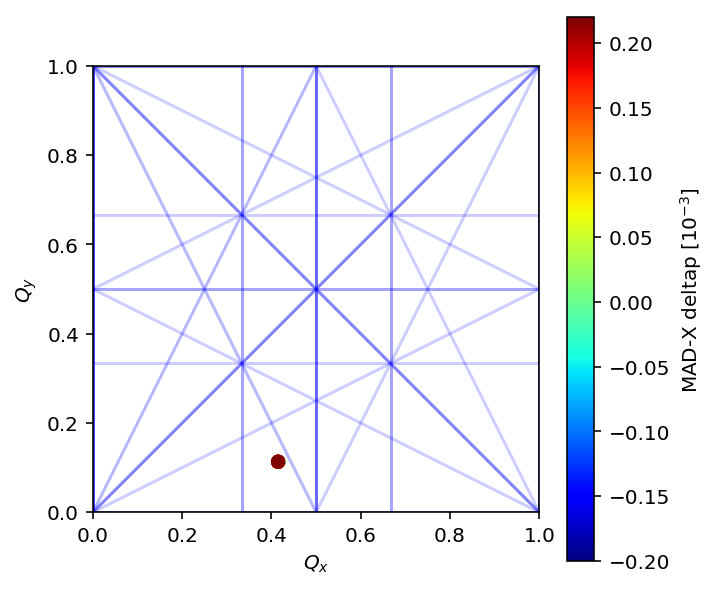

In [37]:
plotTuneDiagram()
Q1=madx.table.summ.q1
Q2=madx.table.summ.q2
plt.scatter(Q1-np.floor(Q1),Q2-np.floor(Q2),c=madx.table.summ.deltap*1000, cmap='jet');
#plt.xlim(1/3-.01,1/2+.01)
#plt.ylim(1/3-.01,1/2+.01)
myColorbar=plt.colorbar()
myColorbar.set_label('MAD-X deltap [$10^{-3}$]')

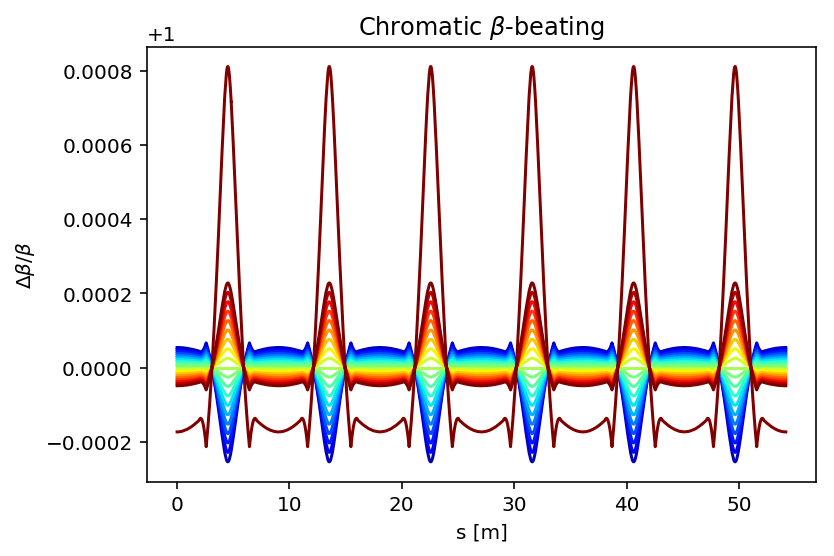

In [38]:
aux2=madx.table.twiss_11.dframe()
myColor=plt.cm.get_cmap('jet', 21)
for i in range(1,21):
    aux1=madx.table[f'twiss_{i}'].dframe()
    plt.plot(aux1.s, aux1.betx/aux2.betx,color=myColor(i))
aux1=madx.table[f'twiss'].dframe()
plt.plot(aux1.s, aux1.betx/aux2.betx,color=myColor(21))
#plt.xlim(0,10)
plt.xlabel('s [m]')
plt.ylabel('$\Delta \\beta/\\beta$')
plt.title('Chromatic $\\beta$-beating');


In [39]:
madx.input('''
ksf=0;
ksd=0;
twiss;''')
twissSextupolesOFF=madx.table.twiss.dframe()
showChroma()

print("=======\nreal Chroma is \nDQ1 = {} \nDQ2 = {}".format(kx/beamFT["beta_r"],ky/beamFT["beta_r"]))

DQ1 = -78.0894
DQ2 = 16.7714
real Chroma is 
DQ1 = -78.08643618538015 
DQ2 = 2.1208409178548093


In [40]:
madx.input('twiss;')
import numpy as np
twissSextupolesOFF=madx.table.twiss.dframe()

dq1=np.mean(madx.table.summ.dq1)
dq2=np.mean(madx.table.summ.dq2)

dq1=kx/beamFT["beta_r"]
dq2=ky/beamFT["beta_r"]


aux=twissSextupolesOFF[twissSextupolesOFF['name']=='YR02KS2:1'.lower()]
bx1=aux['betx'].values[0]
by1=aux['bety'].values[0]
dx1=aux['dx'].values[0]

aux=twissSextupolesOFF[twissSextupolesOFF['name']=='YR02KS1:1'.lower()]
bx2=aux['betx'].values[0]
by2=aux['bety'].values[0]
dx2=aux['dx'].values[0]

####### Solution of the linear problem #######
M=np.array([[bx1*dx1, bx2*dx2],[-by1*dx1, -by2*dx2]])/4./np.pi
mySollution=np.linalg.inv(M)@np.array([[-dq1],[-dq2]])/6
# ! devided by 6
print('=======================================')
print('This is the solution our matrix of the\nintegrated sextupoles strength:')
display(mySollution)
print('=======================================')

This is the solution our matrix of the
integrated sextupoles strength:


array([[-0.62215079],
       [ 0.49738166]])

In [41]:
# MADX matching

madx.input('''
! Matching
match, sequence = cryring;
vary, name =ksf,step=0.00001;
vary, name =ksd,step=0.00001;
global, DQ1=0.0;
global, DQ2=0.0;
Lmdif, calls=100, tolerance=1.0e-40;
endmatch;

twiss;

''')
showChroma()

DQ1 = 3.52658e-14
DQ2 = -1.64105e-14


In [42]:
madx.input(f'''
! FROM the analytical approach
ksf={mySollution[0][0]};
ksd={mySollution[1][0]};
twiss;
''');
showChroma()

DQ1 = -0.00300193
DQ2 = 14.6506


In [43]:
showChroma()

aux=beamFB['deltap_p']
madx.input('twiss, deltap={}:{}:0.00002;'.format(-aux,aux+0.00002));
#madx.input('twiss;');

q1 =madx.table.summ.q1
q2 =madx.table.summ.q2


print(madx.table.summ.dq1)
showChroma()

aux=beamFB['deltap_p']
madx.input('ksf=0;ksd=0;twiss, deltap={}:{}:0.00002;'.format(-aux,aux+0.00002));

showChroma()

DQ1 = -0.00300193
DQ2 = 14.6506
[-0.06796003 -0.06146107 -0.05496281 -0.04846525 -0.04196839 -0.03547223
 -0.02897677 -0.02248201 -0.01598795 -0.00949459 -0.00300193  0.00349004
  0.0099813   0.01647186  0.02296173  0.02945089  0.03593936  0.04242713
  0.0489142   0.05540057  0.06188624  0.06837121]
DQ1 = -0.06796
DQ2 = 14.642
DQ1 = -78.1454
DQ2 = 16.7506


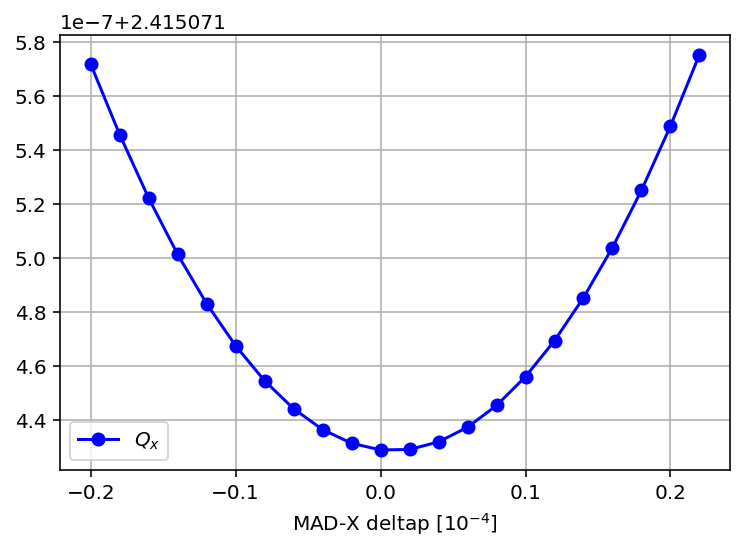

In [44]:
#The non-linear vertical chromaticity is Very clear
plt.plot(madx.table.summ.deltap*1000,q1,'o-b', label='$Q_x$')
#plt.plot(madx.table.summ.deltap*1000,q2,'o-r', label='$Q_y$')

#plt.plot(madx.table.summ.deltap*1000,madx.table.summ.q1,'o-g', label='$Q_x$')
#plt.plot(madx.table.summ.deltap*1000,madx.table.summ.q2,'o-y', label='$Q_y$')


plt.xlabel('MAD-X deltap [$10^{-4}$]')
plt.grid()
plt.legend(loc='best');

In [45]:
print(np.sum(-myTwiss.k1l*myTwiss.betx)/4/np.pi/beamFT["beta_r"])
print(np.sum(myTwiss.k1l*myTwiss.bety)/4/np.pi/beamFT["beta_r"])

24.611195030321795
-112.4959716392687


In [46]:
dqx=np.sum(-myTwissHR.k1l*myTwissHR.betx)/4/np.pi/8
dqy=np.sum(myTwissHR.k1l*myTwissHR.bety)/4/np.pi/8

dqx/beamFT["beta_r"],dqy/beamFT["beta_r"]

(48.56298998191793, -227.0956471213946)

True